In [9]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
import joblib
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
import sys
random_state = 42

In [2]:
joblib.__version__

'1.2.0'

In [5]:
df = pd.read_csv('../data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [10]:
def df_cleaning(df):

    'initial preprocessing of insurance dataset'
    
    print('1. All duplicated rows within dataset will be dropped. Found:', df.duplicated().sum(), 'duplicated rows.')
    df = df.drop_duplicates()
    
    print('2. All missing values within dataset will be replaced with 0. Found:', df.isna().sum().sum(), 'missing values. ')
    df = df.fillna(value=0)
    
    df = pd.get_dummies(df, drop_first=True)
    
    new_cols = [col for col in df.columns if col != 'charges'] + ['charges']
    df = df[new_cols]
    
    return df

In [11]:
df = df_cleaning(df)

1. All duplicated rows within dataset will be dropped. Found: 1 duplicated rows.
2. All missing values within dataset will be replaced with 0. Found: 0 missing values. 


In [12]:
df.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,charges
0,19,27.900,0,0,1,0,0,1,16884.92400
1,18,33.770,1,1,0,0,1,0,1725.55230
2,28,33.000,3,1,0,0,1,0,4449.46200
3,33,22.705,0,1,0,1,0,0,21984.47061
4,32,28.880,0,1,0,1,0,0,3866.85520


In [13]:
X = df.drop('charges', axis = 1)
y = df['charges']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33, random_state = random_state)

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

#czy skalować ? 

In [12]:
XGB_model = xgb.XGBRegressor(max_depth = 3, n_estimators=50, learning_rate =.2,objective='reg:squarederror')
XGB_model.fit(X_train, y_train);

In [13]:
def show_metrics(model,x_test,y_test):
    y_pred = model.predict(x_test)
    MAE_XGB= metrics.mean_absolute_error(y_test, y_pred)
    MSE_XGB = metrics.mean_squared_error(y_test, y_pred)
    RMSE_XGB =np.sqrt(MSE_XGB)
    R2_XGB_perc = (metrics.r2_score(y_test, y_pred))*100
    print("RMSE: {:.4f}, R2: {:.2f}%, MSE: {:.4f}".format(RMSE_XGB,R2_XGB_perc,MSE_XGB))

In [14]:
show_metrics(XGB_model,X_test,y_test)

RMSE: 4640.6980, R2: 87.34%, MSE: 21536077.8569


In [15]:
scores = cross_val_score(XGB_model, X_train, y_train, cv=5)
print(np.sqrt(scores))

[0.91330098 0.91258463 0.93111292 0.92244111 0.91315897]


In [18]:
feats = df.columns.to_list()
feats

['age',
 'bmi',
 'children',
 'sex_male',
 'smoker_yes',
 'region_northwest',
 'region_southeast',
 'region_southwest',
 'charges']

In [19]:
import scikitplot as skplt
def plot_feature_importances(model, feat_list):

    model_name = type(model).__name__
    skplt.estimators.plot_feature_importances(model, feature_names=df[feat_list].columns,
                                            title=f'{model_name} feature importances')
    plt.xticks(rotation=90)

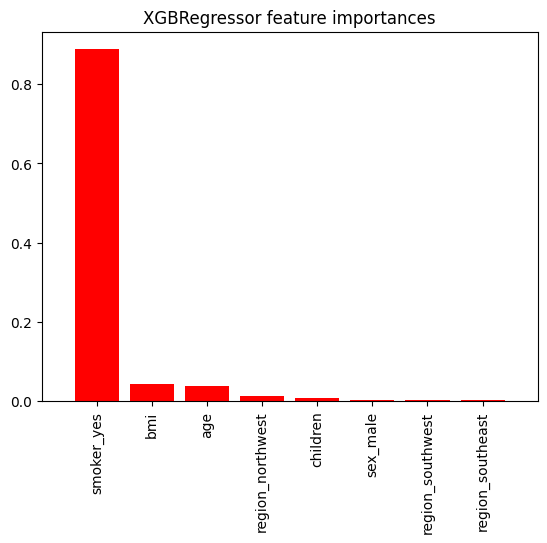

In [20]:
plot_feature_importances(XGB_model,feats)

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

In [36]:

def run_xgb_hyperopt(x_train, y_train, x_test,y_test, cv, max_evals, random_state):
    
    # funkcja, której wynik chcemy minimalizować (RMSE)
    def objective(space):
        XGB_model = xgb.XGBRegressor(
        learning_rate=space['learning_rate'],
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        min_child_weight=int(space['min_child_weight']),
        gamma=space['gamma'],
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        objective='reg:squarederror',
        random_state = random_state, 
        n_jobs = -1
    )
               
        XGB_model.fit(x_train, y_train, verbose=False)
        y_pred = XGB_model.predict(x_test)

        rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
            
        print("RMSE: {:.4f}".format(rmse))
        return{'loss': rmse, 'status': STATUS_OK }
    
    # parametry do optymizacji    
    space = {
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.3, 0.01),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'max_depth': hp.quniform('max_depth', 2, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'gamma': hp.quniform('gamma', 0.0, 1.0, 0.01),
    'subsample': hp.quniform('subsample', 0.1, 1.0, 0.01),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 0),
    'reg_lambda': hp.loguniform('reg_lambda', -5, 0)
    }

    trials = Trials() # przechowuje info dla kazdego kroku.
    
    best = fmin(fn=objective , #fmin - funkcja, ktora chcemy minimalizowac
                space=space, #przestrzeń potencjalnych (hyper)parametrów
                algo=tpe.suggest, #algorytm wyszukujacy najlepsze parametry
                max_evals=max_evals, #ilość prób
                trials=trials) #zapisywane wynikow w trakcie
    
    hyperparams = space_eval(space, best)

    print("The best params: ", hyperparams)
    return hyperparams

In [37]:
x_train_v = X_train.values
y_train_v = y_train.values
x_test_v = X_test.values
y_test_v = y_test.values


In [38]:
best_XGB = run_xgb_hyperopt(x_train_v,y_train_v,x_test_v,y_test_v,cv=kf,max_evals=3000, random_state = random_state)

RMSE: 5600.0297                                         
RMSE: 6209.7814                                                                  
RMSE: 5153.3681                                                                  
RMSE: 5072.3154                                                                  
RMSE: 6038.9504                                                                  
RMSE: 7127.9153                                                                  
RMSE: 6925.1020                                                                  
RMSE: 7094.5182                                                                  
RMSE: 5775.2542                                                                  
RMSE: 5443.5649                                                                  
RMSE: 6571.9643                                                                   
RMSE: 5940.5643                                                                   
RMSE: 5131.9405                        

In [39]:
best_XGB

{'colsample_bytree': 1.0,
 'gamma': 0.22,
 'learning_rate': 0.01,
 'max_depth': 3.0,
 'min_child_weight': 2.0,
 'n_estimators': 555.0,
 'reg_alpha': 0.014742226451057563,
 'reg_lambda': 0.024343086733675086,
 'subsample': 1.0}

In [25]:
best = {'colsample_bytree': 0.97,
 'gamma': 0.12,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 5.0,
 'n_estimators': 423,
 'reg_alpha': 0.018634811484198422,
 'reg_lambda': 0.011160725546019646,
 'subsample': 0.3} 
 #inna pula parametrow po optymalizacji 

In [41]:
""""best_XGB = {'colsample_bytree': 0.98,
 'gamma': 0.85,
 'learning_rate': 0.03,
 'max_depth': 3.0,
 'min_child_weight': 9.0,
 'n_estimators': 214.0,
 'reg_alpha': 0.6484089080929396,
 'reg_lambda': 0.01632422601212419,
 'subsample': 0.45}"""

'"best_XGB = {\'colsample_bytree\': 0.98,\n \'gamma\': 0.85,\n \'learning_rate\': 0.03,\n \'max_depth\': 3.0,\n \'min_child_weight\': 9.0,\n \'n_estimators\': 214.0,\n \'reg_alpha\': 0.6484089080929396,\n \'reg_lambda\': 0.01632422601212419,\n \'subsample\': 0.45}'

In [99]:
best_XGB = {'colsample_bytree': 1.0,
 'gamma': 0.22,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 2.0,
 'n_estimators': 555,
 'reg_alpha': 0.014742226451057563,
 'reg_lambda': 0.024343086733675086,
 'subsample': 1.0}

In [100]:
XGB_model_tuned = xgb.XGBRegressor(**best_XGB,random_state=random_state)

In [101]:
XGB_model_tuned.fit(X_train,y_train)
y_pred_XGB = XGB_model_tuned.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test,y_pred_XGB))

4597.2033009788265

In [102]:
show_metrics(XGB_model_tuned,X_test,y_test)

RMSE: 4597.2033, R2: 87.58%, MSE: 21134278.1905


In [103]:
joblib.dump(XGB_model_tuned,'model_xgb_fe_mz')

['model_xgb_fe_mz']

In [3]:
xgbmz = joblib.load('model_xgb_fe_mz')

In [17]:
xgbmz.feature_names_in_

array(['age', 'bmi', 'children', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='<U16')